# Spatial-temporal analysis
To probe spatial-temporal dynamics during early development, we used `SLAT` to align two spatial atlases of developing mouse embryonic at E11.5 and E12.5 via Stereo-seq data ([Chen. et al](https://www.sciencedirect.com/science/article/pii/S0092867422003993?via%3Dihub)). We did subsample of each dataset to ~10,000 cells for the purpose of demonstration.

You need following files as input:

 * adata1.h5ad: E11.5 mouse embryo dataset, download from [here](https://drive.google.com/uc?export=download&id=1KkuJt6aSlKS1AJzFZjE_odypY-GINRuD)
 * adata2.h5ad: E12.5 mouse embryo dataset, download from [here](https://drive.google.com/uc?export=download&id=1YIiEmjGfHxcDbGn4nv2kzmTHUo3_q5hJ)

In [1]:
import os

import scanpy as sc
import numpy as np
import pandas as pd
import torch

import scSLAT
from scSLAT.model import load_anndatas, Cal_Spatial_Net, run_SLAT, scanpy_workflow, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey, match_3D_celltype, Sankey
from scSLAT.metrics import region_statistics

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-alvj89z4 because the default path (/home/xiacr/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc.set_figure_params(dpi=100, dpi_save=150)

In [3]:
adata1 = sc.read_h5ad('adata1.h5ad')
adata2 = sc.read_h5ad('adata2.h5ad')

We visualize the dataset and colored by cell type annotation.

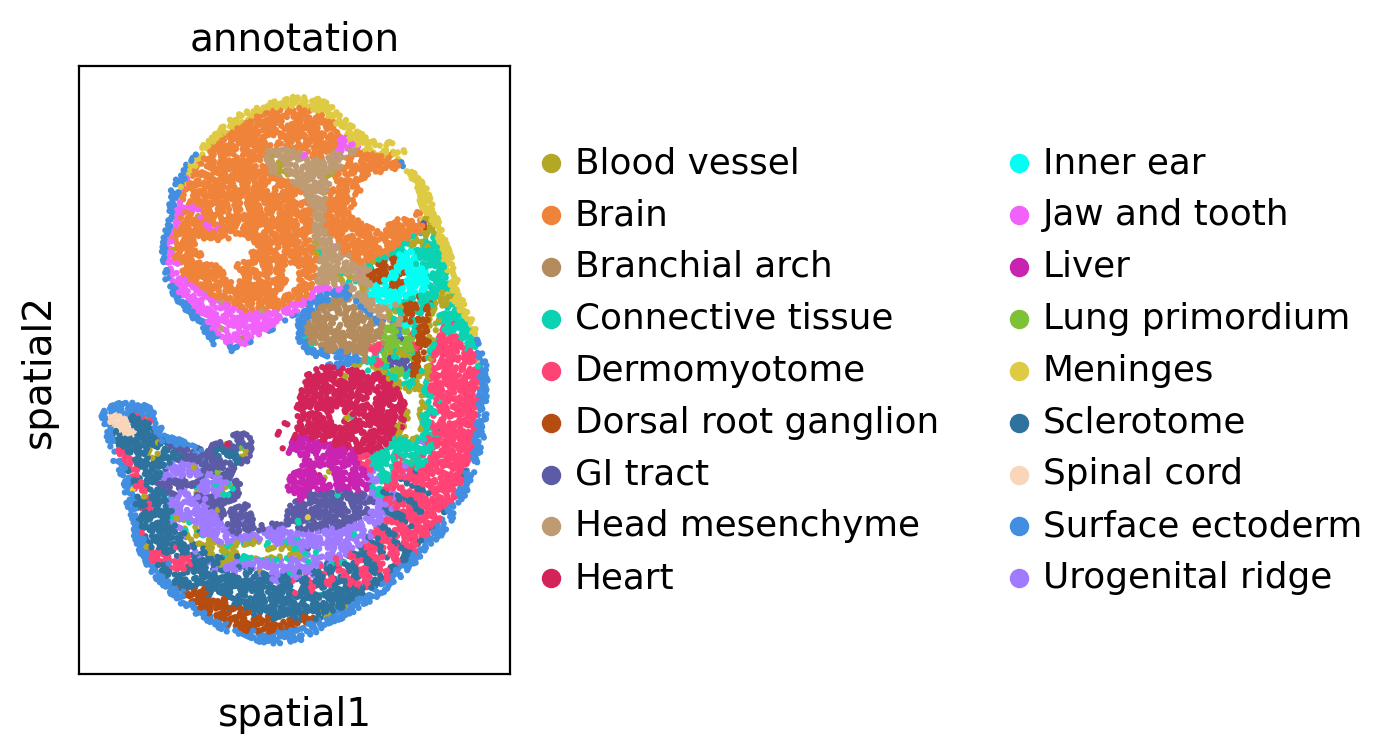

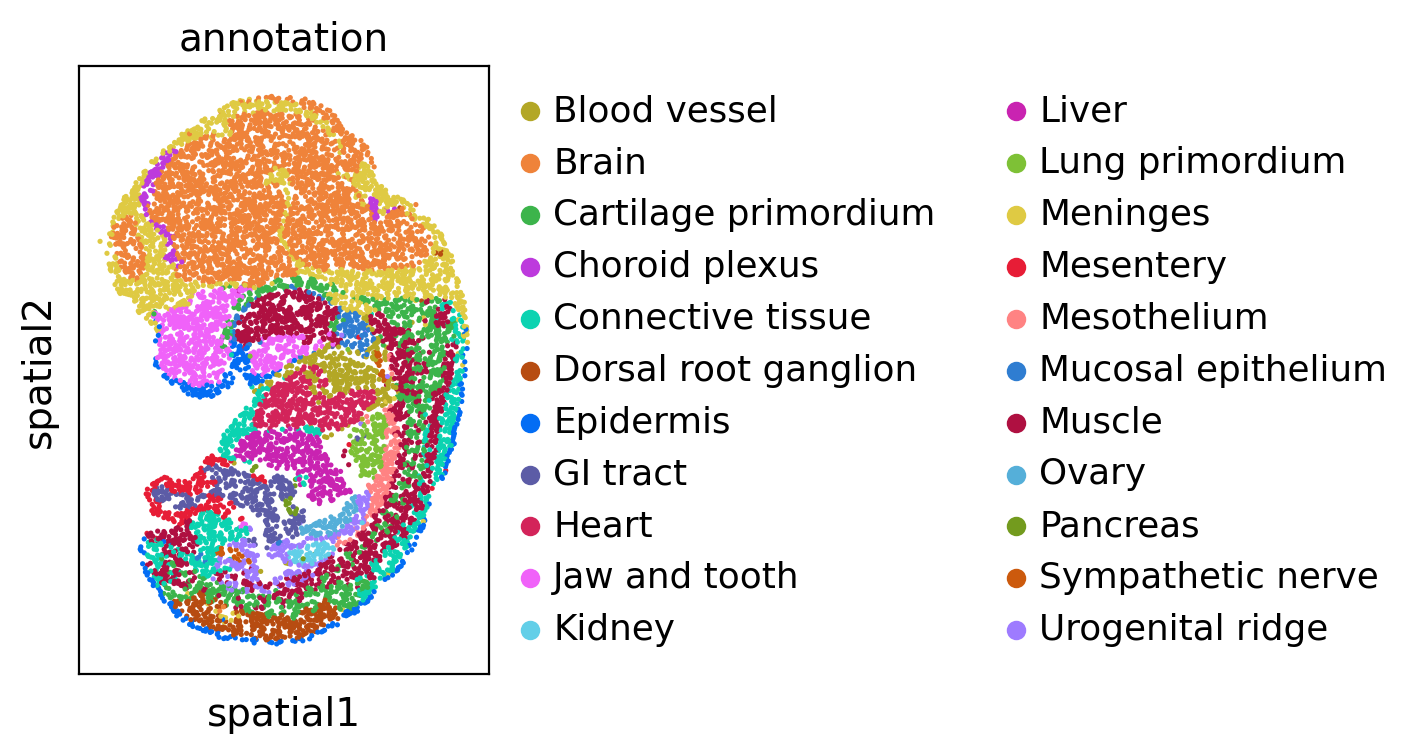

In [4]:
sc.pl.spatial(adata1, color='annotation', spot_size=3)
sc.pl.spatial(adata2, color='annotation', spot_size=3)

## Run SLAT
Then we run SLAT as usual

In [5]:
Cal_Spatial_Net(adata1, k_cutoff=20, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=20, model='KNN')
edges, features = load_anndatas([adata1, adata2], feature='DPCA', check_order=False)

Calculating spatial neighbor graph ...
The graph contains 537308 edges, 10000 cells.
53.7308 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 539939 edges, 10001 cells.
53.98850114988501 neighbors per cell on average.
Use DPCA feature to format graph


/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)
/rd2/user/xiacr/SLAT/conda/lib/python3.

Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!


In [6]:
embd0, embd1, time = run_SLAT(features, edges, LGCN_layer=5)

Choose GPU:5 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 1.83


In [7]:
best, index, distance = spatial_match([embd0, embd1], reorder=False, adatas=[adata1,adata2])

In [8]:
adata1_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['annotation']})
matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match, start=0.5, number_of_interval=10)

0.500~0.550        11          0.110%
0.550~0.600        46          0.460%
0.600~0.650       234          2.340%
0.650~0.700       640          6.399%
0.700~0.750      1187         11.869%
0.750~0.800      1553         15.528%
0.800~0.850      1830         18.298%
0.850~0.900      1821         18.208%
0.900~0.950      2039         20.388%
0.950~1.000       637          6.369%


## Visualization of alignment

dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Spinal cord', 'Branchial arch', 'Sclerotome', 'Inner ear', 'Dermomyotome', 'Surface ectoderm', 'Head mesenchyme', 'Sympathetic nerve', 'Ovary', 'Muscle', 'Kidney', 'Mucosal epithelium', 'Mesentery', 'Mesothelium', 'Choroid plexus', 'Cartilage primordium', 'Epidermis', 'Pancreas']]
Subsample 300 cell pairs from 10001


/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


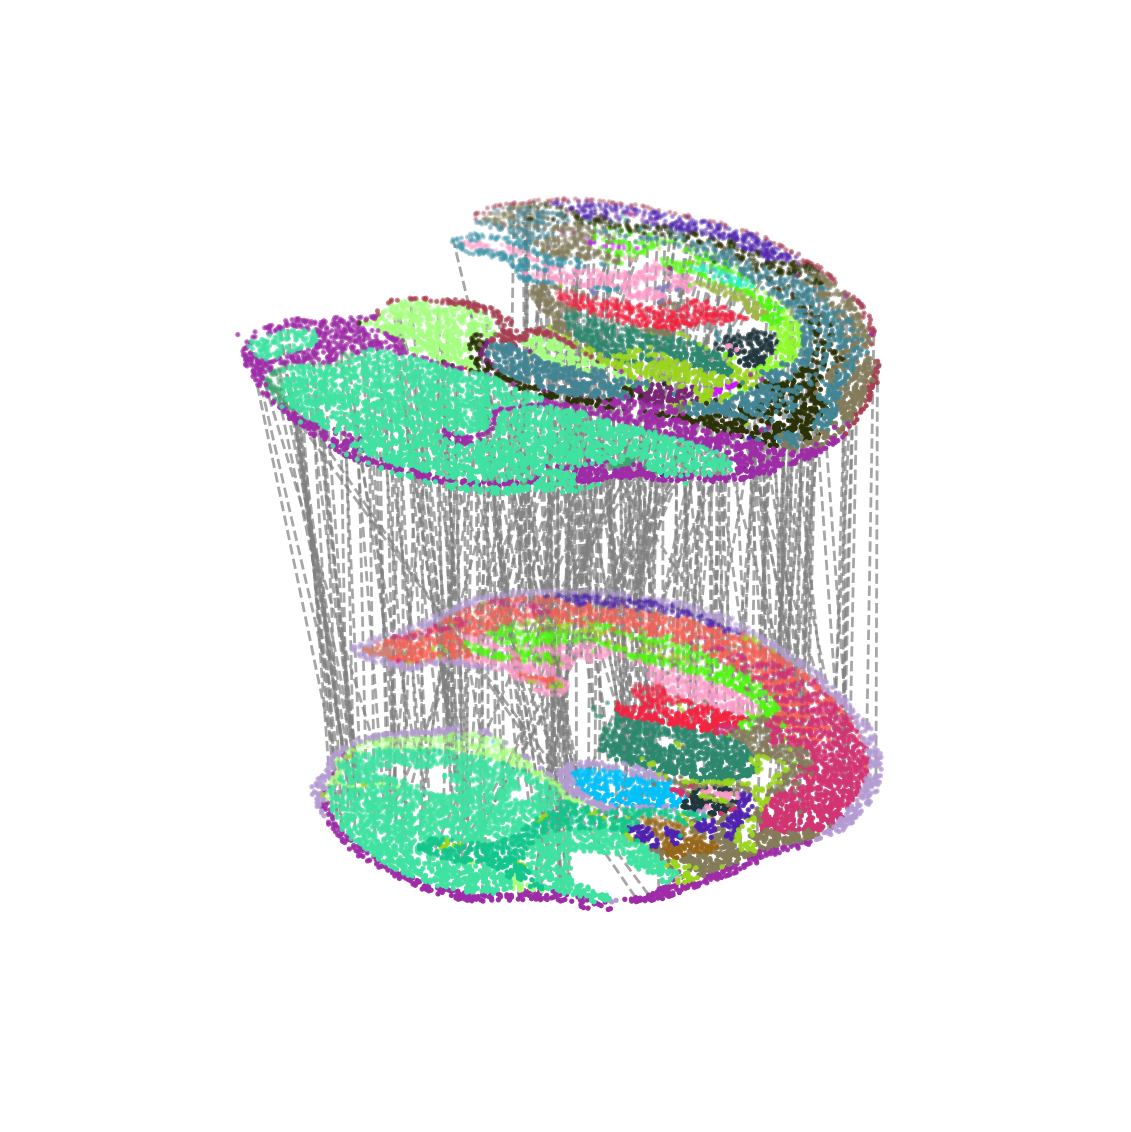

In [9]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align.draw_3D(size=[7, 8], line_width =1, point_size=[0.8,0.8], hide_axis=True, show_error=False)

In [10]:
adata2.obs['low_quality_index']= best_match 
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)

Then we check the alignment quality of the whole slide

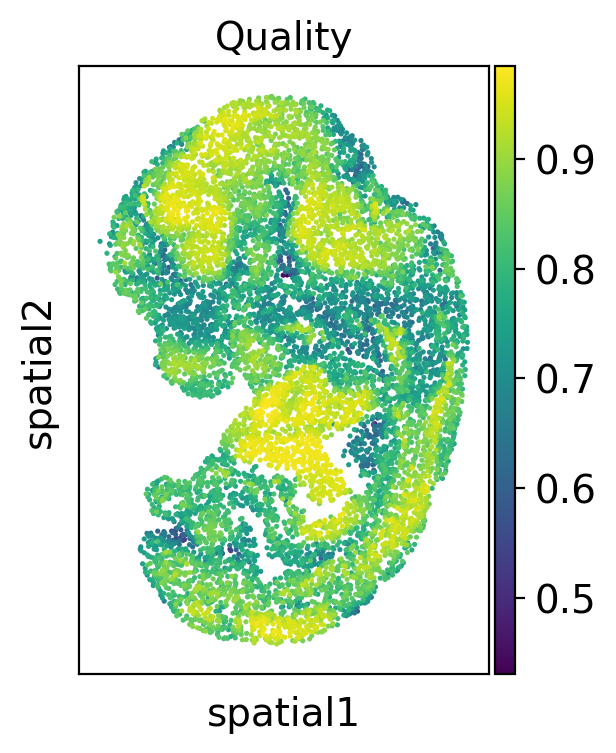

In [11]:
sc.pl.spatial(adata2, color='low_quality_index', spot_size=3, title='Quality')

We use a Sankey diagram to show the correspondence between cell types at different stages of development

In [12]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()

In [13]:
matching_table = adata2_df.groupby(['celltype', 'target_celltype']).size().unstack(fill_value=0)

In [14]:
Sankey(matching_table, layout=[1000,800], font_size=15)

## Focus on developing Kidney
We highlighted the "Kidney" cells in E12.5 and their aligned precursor cells in E11.5 in alignment results. Consistent with our biological priors, the precursors of the kidney are the mesonephros and the metanephros

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Spinal cord', 'Branchial arch', 'Sclerotome', 'Inner ear', 'Dermomyotome', 'Surface ectoderm', 'Head mesenchyme', 'Sympathetic nerve', 'Ovary', 'Muscle', 'Kidney', 'Mucosal epithelium', 'Mesentery', 'Mesothelium', 'Choroid plexus', 'Cartilage primordium', 'Epidermis', 'Pancreas']]
Subsample 10000 cell pairs from 10001


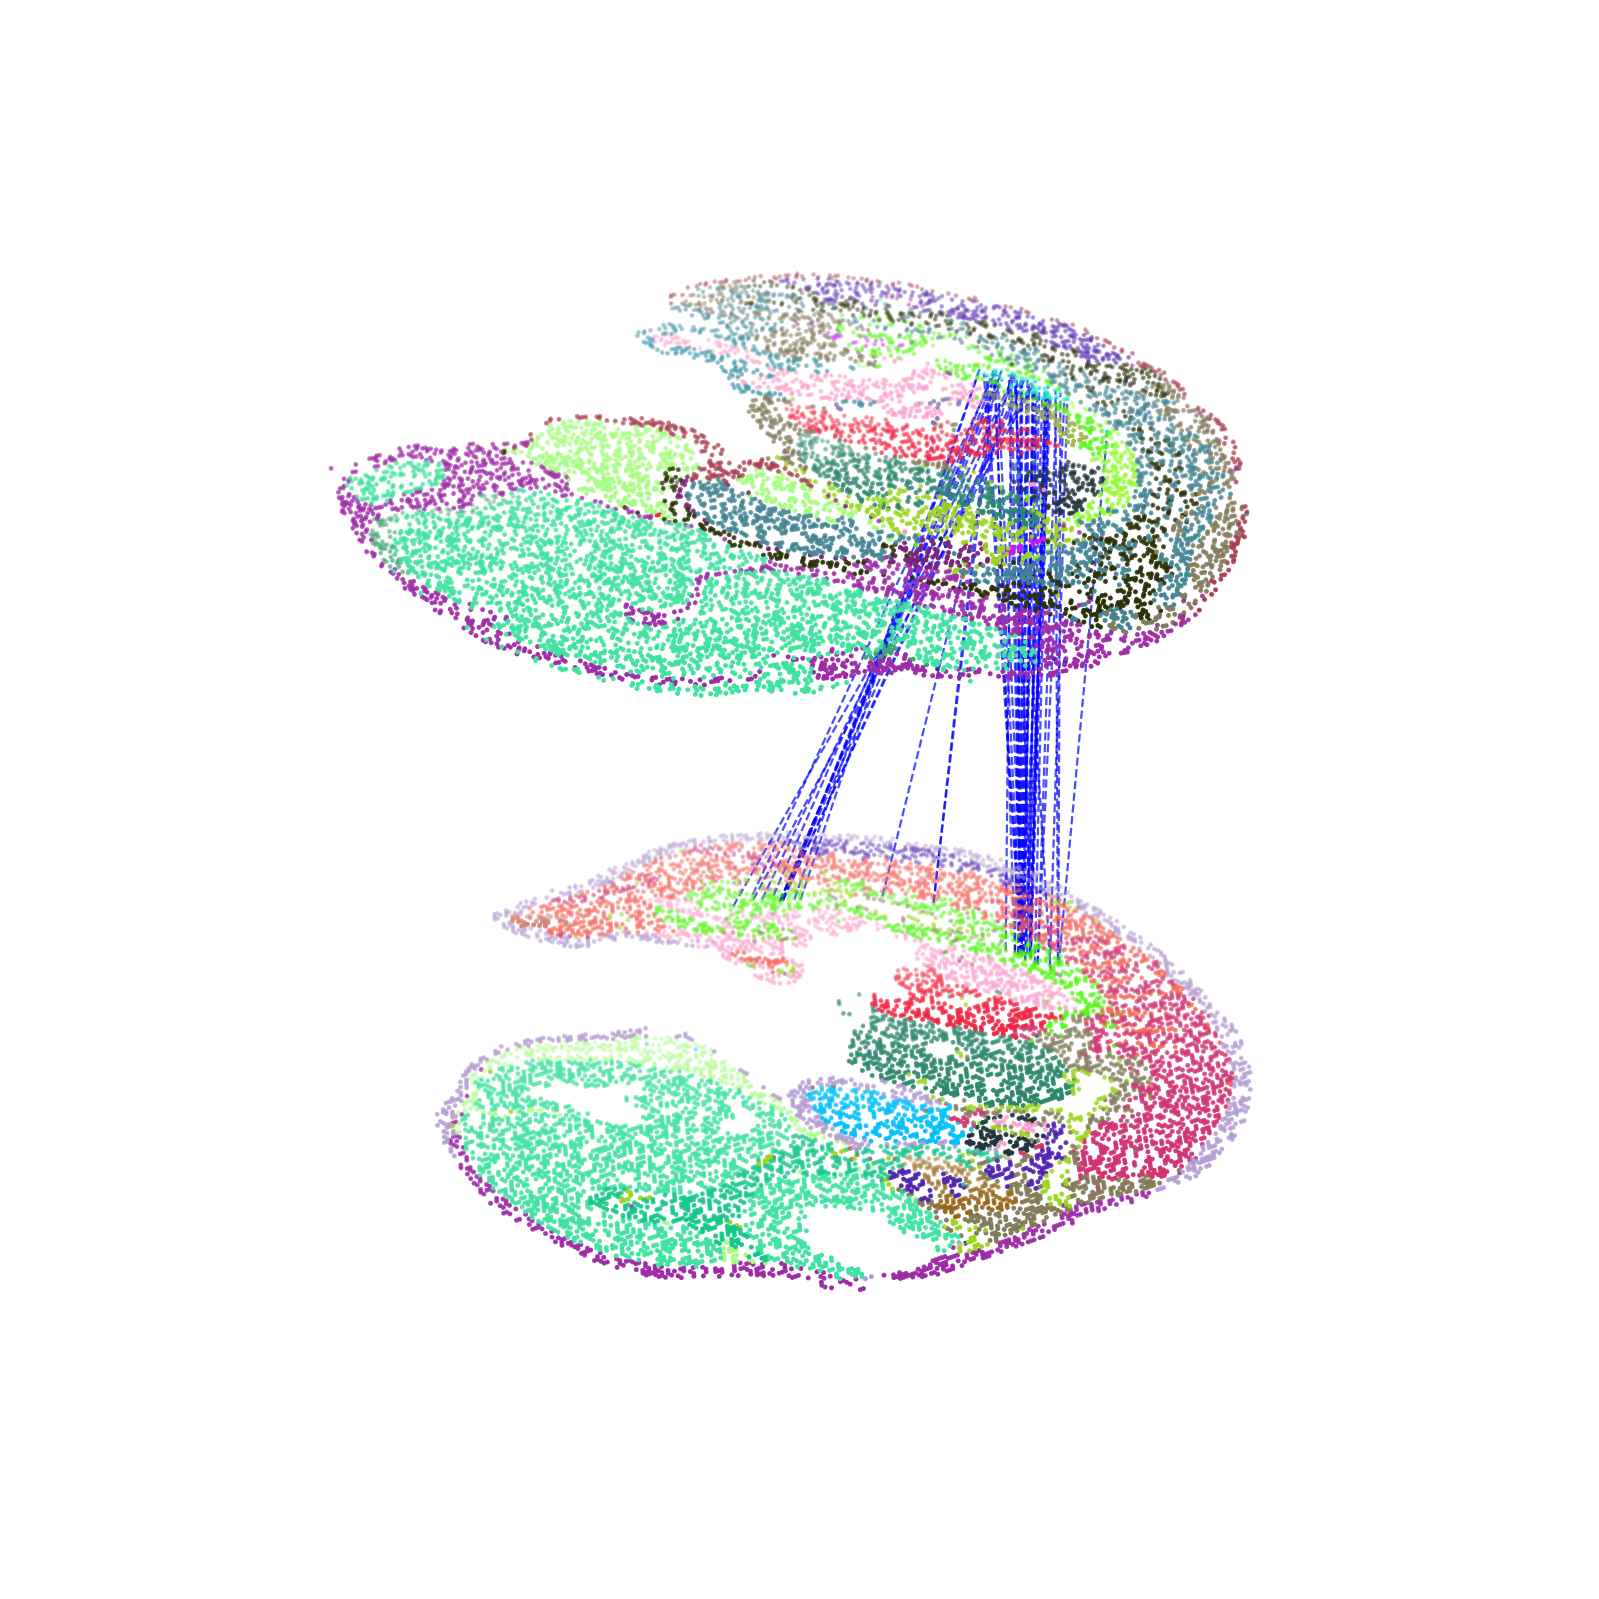

In [15]:
kidney_align = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype = [['Urogenital ridge'],['Kidney']],
                                 subsample_size=10000, highlight_line = ['blue'], scale_coordinate = True )
kidney_align.draw_3D(size= [10, 12], line_width =0.8, point_size=[0.6,0.6], hide_axis=True)

## Focus on developing Ovary
Then we focus on another organ: 'Ovary', and found ovary only has single spatial origin. It is interesting that precursors of ovary are spatially close to the mesonephros (see Kidney part), because mammalian ovary originates from the regressed mesonephros.

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:204: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Spinal cord', 'Branchial arch', 'Sclerotome', 'Inner ear', 'Dermomyotome', 'Surface ectoderm', 'Head mesenchyme', 'Sympathetic nerve', 'Ovary', 'Muscle', 'Kidney', 'Mucosal epithelium', 'Mesentery', 'Mesothelium', 'Choroid plexus', 'Cartilage primordium', 'Epidermis', 'Pancreas']]
Subsample 10000 cell pairs from 10001


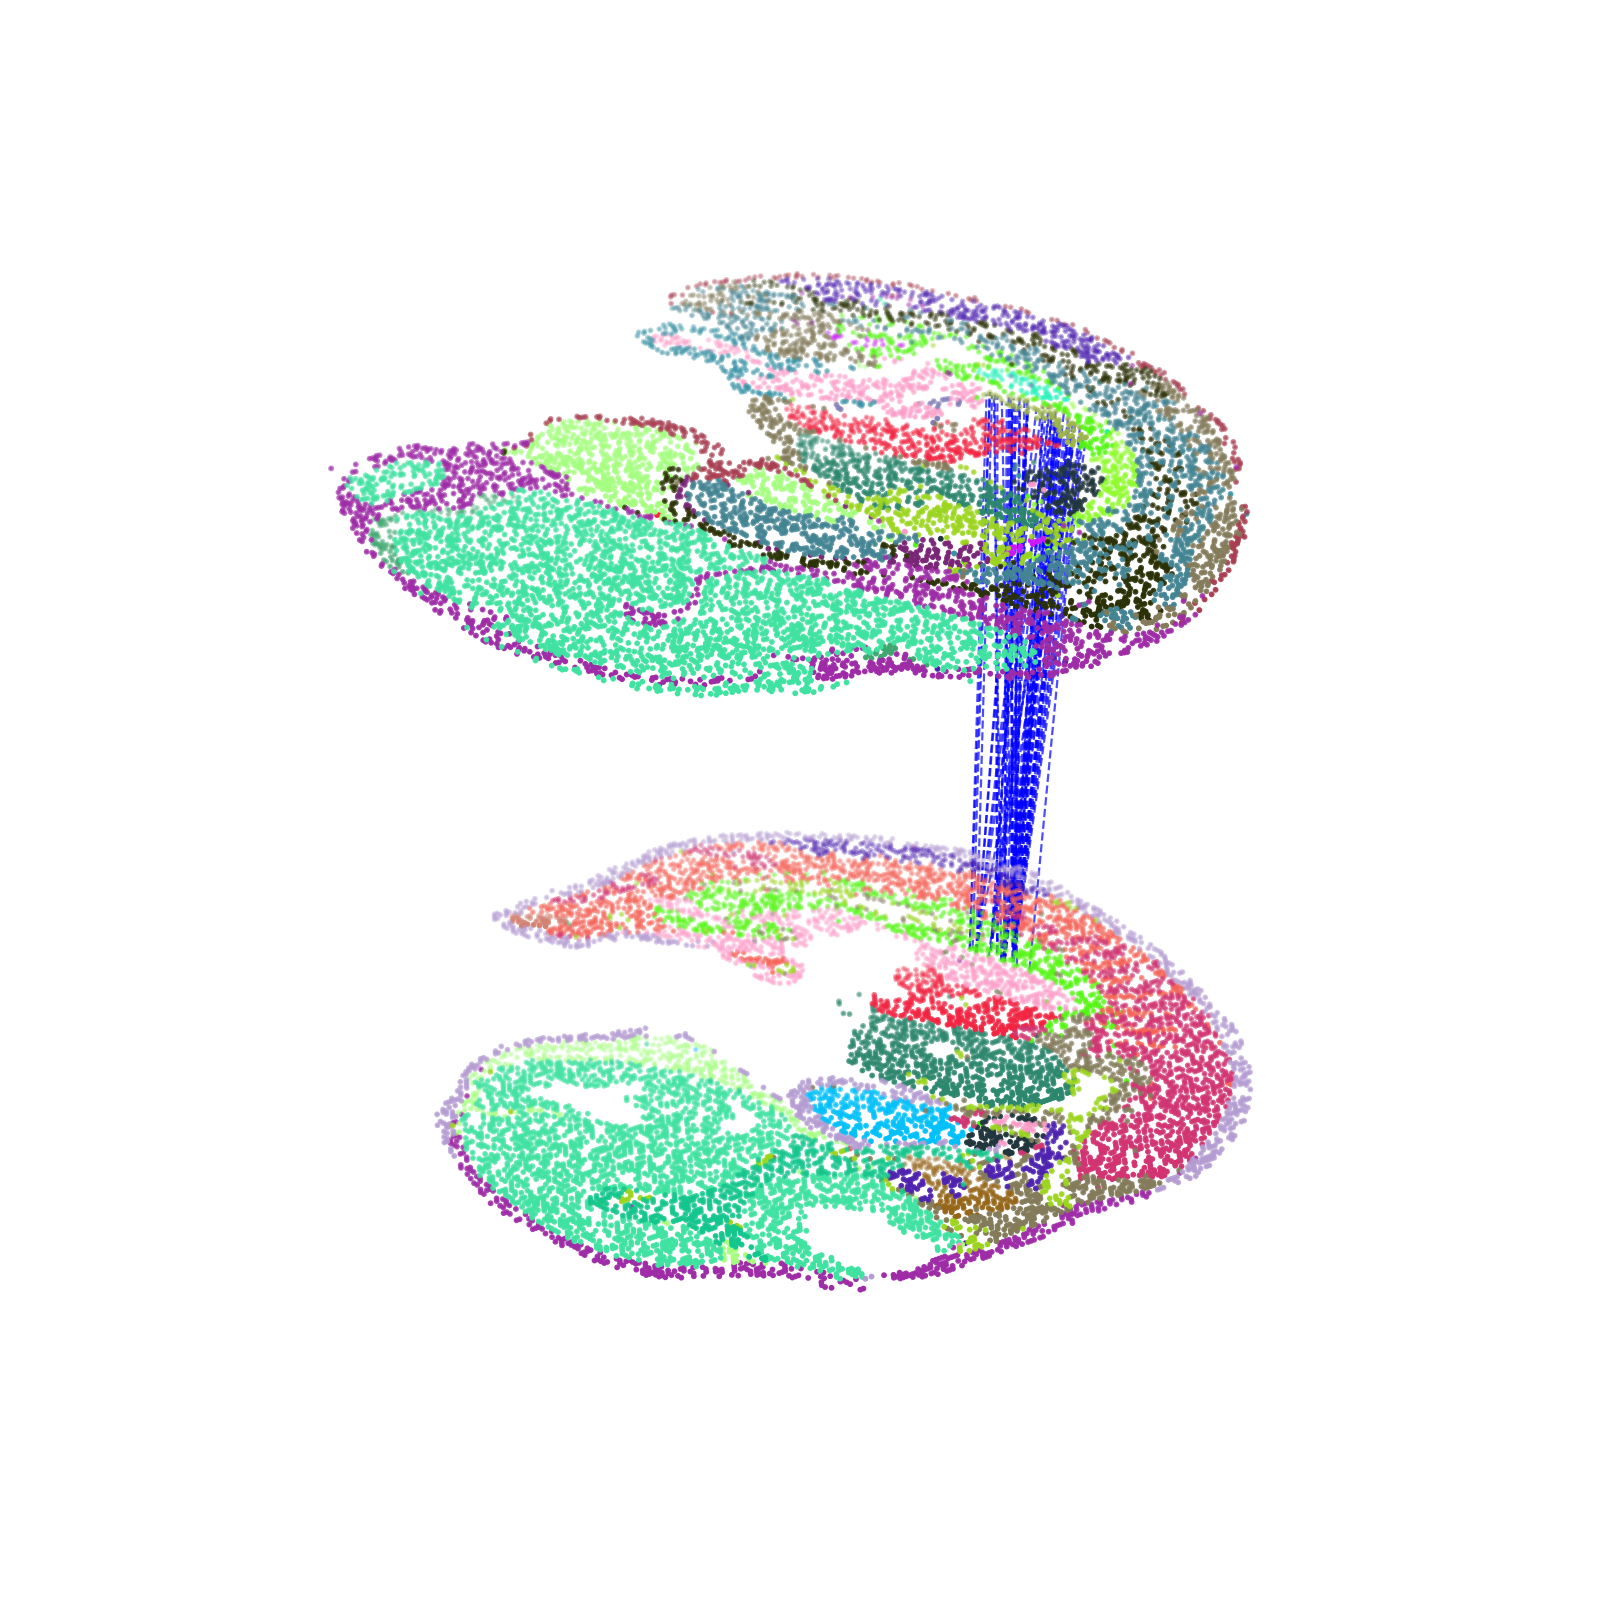

In [16]:
Ovary_align = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype = [['Urogenital ridge'],['Ovary']], 
                                subsample_size=10000, highlight_line = ['blue'], scale_coordinate = True)
Ovary_align.draw_3D(size= [10, 12], line_width =0.8, point_size=[1.2,1.2], hide_axis=True)